* Explore Data
* Feature extraction
* Training Classifier
* scroll window to analysis image

## Explore Data


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import random
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time
from scipy.ndimage.measurements import label

#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles

def load_files(start_dir,files,suffix):
    for dr,_,_ in os.walk(start_dir):
        files.extend(glob.glob(os.path.join(dr,suffix)))        
    return files

def load_data(start_path,suffix='*.png'):
    files=[]
    imgs=[]
    suffix='*.png'
    files=load_files(start_path,files,suffix)
    for filename in files:
        imgs.append(cv2.imread(filename))
    return files,imgs

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    
    test_image = car_list[0]
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_image.shape 
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_image.dtype
    # Return data_dict
    
    return data_dict

In [2]:
def display_image(img, title):
    plt.title(title)
    plt.imshow(img)
    plt.show()

In [3]:
glob.__file__

'/Users/hubing/anaconda/lib/python3.6/glob.py'

In [4]:


cars,cars_images=load_data('data/vehicles')
notcars,notcars_images=load_data('data/non-vehicles')
print(len(cars_images))
print(len(notcars_images))

#load_data('data/vehicles_smallset/cars1','.jpeg')
#load_data('data/non-vehicles_smallset/notcars1','.jpeg')

8792
8968


In [5]:
data_info=data_look(cars_images,notcars_images)

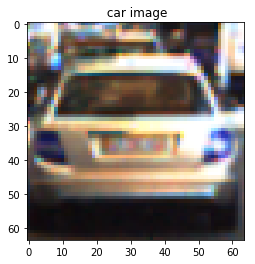

In [6]:
display_image(cars_images[random.randint(0, data_info['n_cars'])], ' car image')


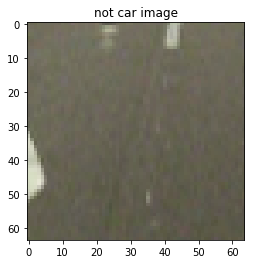

In [7]:
display_image(notcars_images[random.randint(0, data_info['n_notcars'])], 'not car image')


# Color Histogram


# HOG Classify

# Combine Different feature together

In [8]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True

            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)

        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


/Users/hubing/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:


        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)



# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


In [10]:
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler

X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))





/Users/hubing/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [11]:
car_features[0].shape

(6108,)

In [12]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
0.18 Seconds to train SVC...
Test Accuracy of SVC =  1.0


/Users/hubing/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


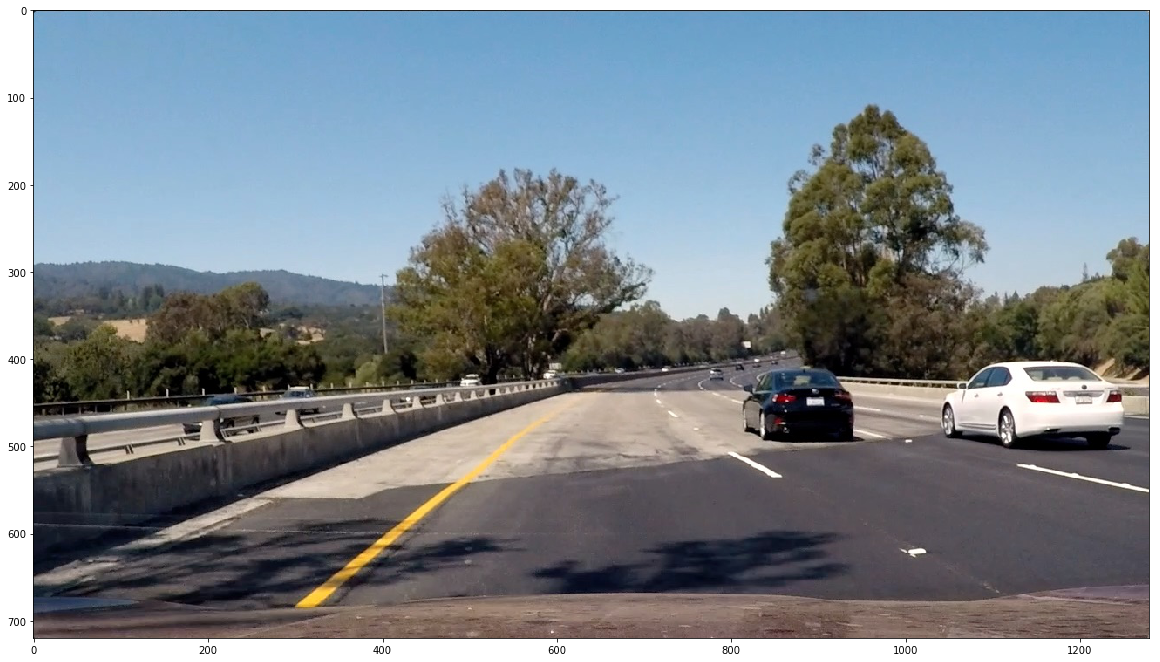

In [13]:

image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.figure(figsize=(20, 20))
plt.imshow(window_img)
plt.show()

In [14]:
svc

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [15]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    windows=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            #print(hog_features.shape)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

        

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))   
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return windows



/Users/hubing/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


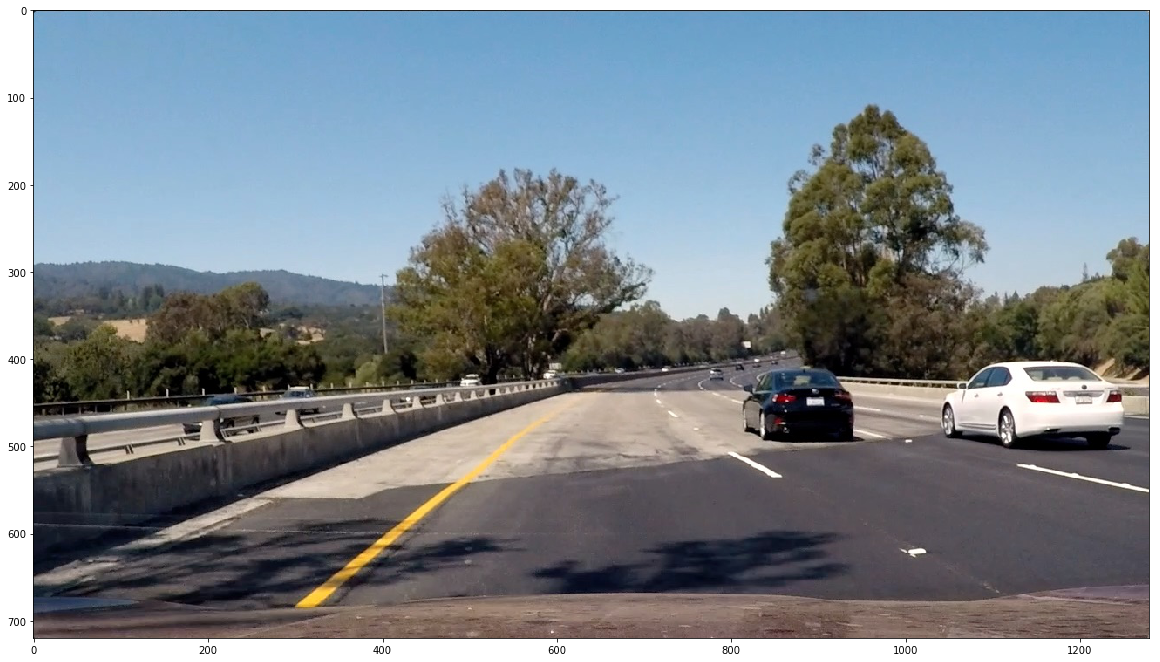

In [16]:
    
ystart = 400
ystop = 656
scale = 1.5
    
windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
draw_img = np.copy(image)
draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)  
fig=plt.figure(figsize=(20,20))
plt.imshow(draw_img)
plt.show()

In [17]:
plt.show()


In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_labels(heatmap_img):
    return label(heatmap_img)

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

/Users/hubing/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


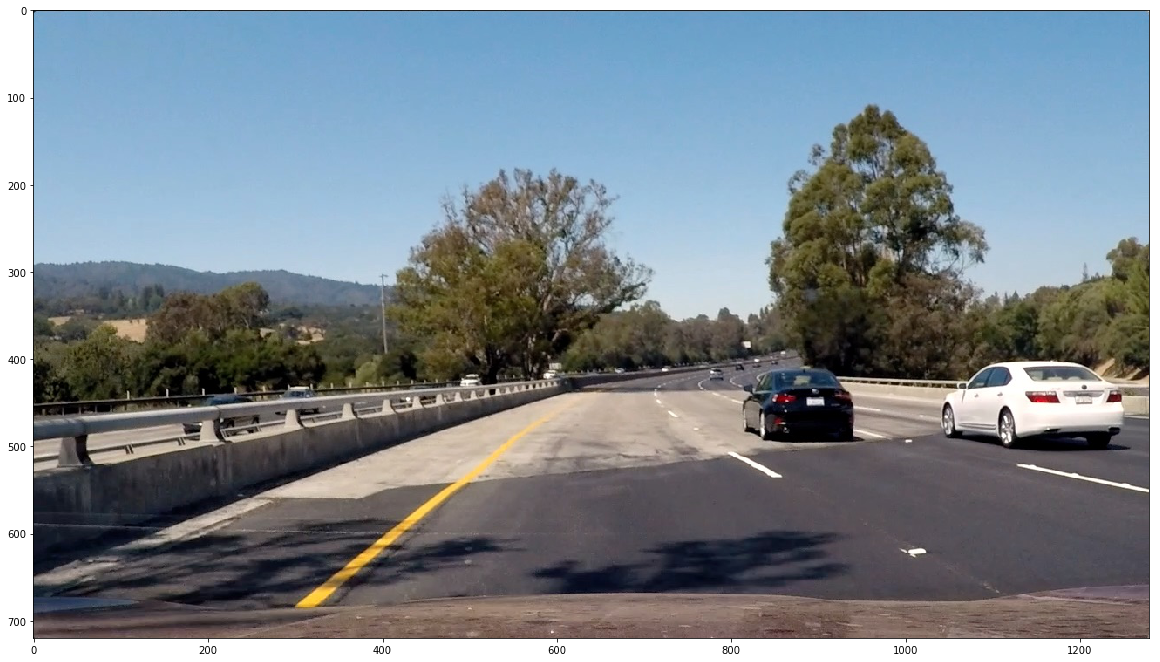

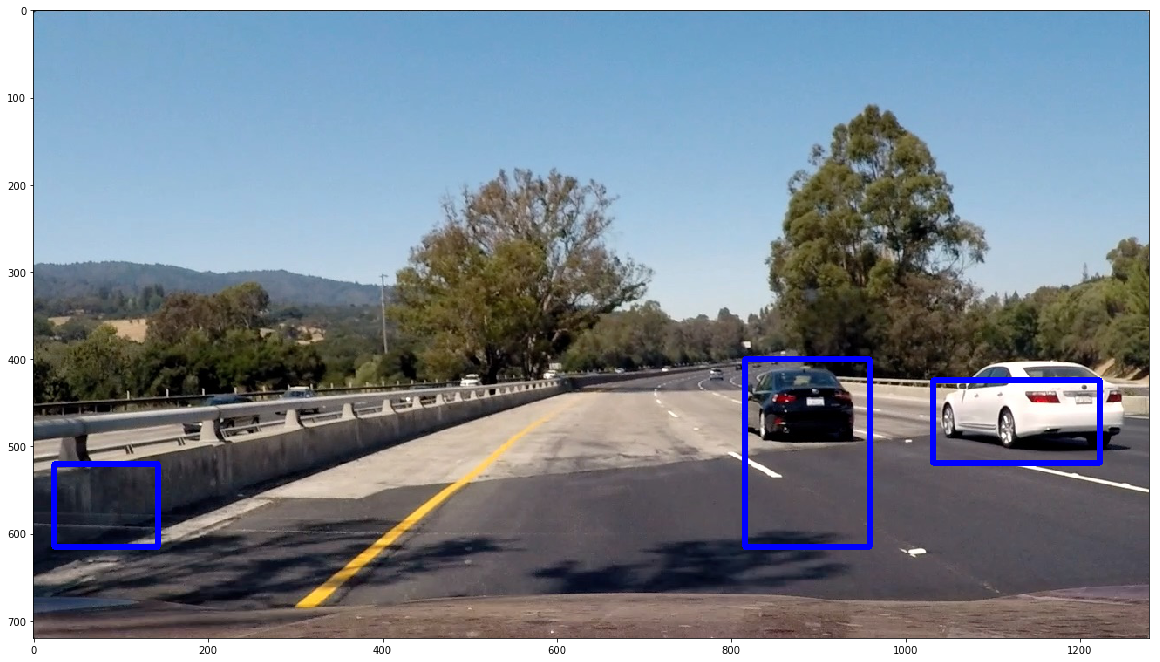

In [19]:
windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
draw_img = np.copy(image)
draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)  
fig=plt.figure(figsize=(20,20))
plt.imshow(draw_img)
plt.show()

heatmap_img = np.zeros_like(image[:,:,0])
heatmap_img=add_heat(heatmap_img,windows)
heatmap_img=apply_threshold(heatmap_img,1)
labels=get_labels(heatmap_img)
draw_labeled_bboxes(draw_img,labels)
fig=plt.figure(figsize=(20,20))
plt.imshow(draw_img)
plt.show()


# Video handle



In [ ]:
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
def process_rectangles(img):
    rectangles = []
    ystart = 400
    ystop = 656
    scale = 1.5

    windows=find_cars(img, ystart, ystop,scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rectangles.extend(windows)
    return rectangles

def process_frame(img):
    rectangles = process_rectangles(img)
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = get_labels(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
bVideo=True
white_output = 'p5_processed_video_project.mp4'

clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(lambda img: process_frame(img))
%time white_clip.write_videofile(white_output, audio=False)

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 400), (240, 496)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 400), (264, 496)), ((168, 448), (264, 544)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 448), (288, 544))

  0%|          | 1/1261 [00:00<07:21,  2.85it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 400), (240, 496)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 400), (264, 496)), ((168, 448), (264, 544)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 448), (288, 544))

  0%|          | 2/1261 [00:00<07:17,  2.88it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 520), (168, 616)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((192, 424), (288, 520)), ((192, 520), (288, 616)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((216, 472), (312, 568)), ((216, 520), (312, 616)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((240, 448), (336, 544)), ((240, 520), (336, 616)), ((264, 424), (360, 520)), ((264, 520), (360, 616)), ((288, 448), (384, 544)), ((288, 520), (384, 616)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 472), (624, 568)), ((528, 496),

  0%|          | 3/1261 [00:01<07:13,  2.91it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 400), (120, 496)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 520), (168, 616)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((216, 472), (312, 568)), ((216, 520), (312, 616)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((240, 448), (336, 544)), ((240, 520), (336, 616)), ((264, 520), (360, 616)), ((480, 520), (576,

  0%|          | 4/1261 [00:01<07:09,  2.93it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 520), (168, 616)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((144, 448), (240, 544)), ((168, 424), (264, 520)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 400), (312, 496)), ((216, 520), (312, 616)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((240, 520), (336, 616)), ((264, 424), (360, 520)), ((264, 520), (360, 616)), ((336, 400), (432, 496)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 496), (624, 

  0%|          | 5/1261 [00:01<07:21,  2.84it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 400), (120, 496)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((120, 448), (216, 544)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 424), (312, 520)), ((240, 424), (336, 520)), ((264, 520), (360, 616)), ((336, 400), (432, 496)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 448), (72

  0%|          | 6/1261 [00:02<07:22,  2.84it/s]

[((0, 448), (96, 544)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 448), (216, 544)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((240, 400), (336, 496)), ((528, 448), (624, 544)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 448), (720, 544)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((648, 520), (744, 616)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((696

  1%|          | 7/1261 [00:02<07:17,  2.87it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((72, 448), (168, 544)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((168, 472), (264, 568)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((240, 520), (336, 616)), ((264, 400), (360, 496)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 424), (672, 520)), ((600, 520), (696, 616)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((648, 520), (744, 616)), ((672, 472), (768, 568)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((696

  1%|          | 8/1261 [00:02<07:14,  2.88it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 472), (192, 568)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 400), (264, 496)), ((168, 424), (264, 520)), ((192, 400), (288, 496)), ((192, 448), (288, 544)), ((240, 520), (336, 616)), ((264, 424), (360, 520)), ((264, 448), (360, 544)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((600, 520), (696, 616)), ((624, 424), (720, 520)), ((624, 472),

  1%|          | 9/1261 [00:03<07:13,  2.89it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 424), (288, 520)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((240, 448), (336, 544)), ((240, 520), (336, 616)), ((264, 520), (360, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((600, 520), (696, 616)), ((624, 472), (720, 568)), ((624, 496), 

  1%|          | 10/1261 [00:03<07:13,  2.89it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 472), (168, 568)), ((96, 424), (192, 520)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((240, 520), (336, 616)), ((264, 520), (360, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520

  1%|          | 11/1261 [00:03<07:07,  2.92it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 472), (168, 568)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((120, 400), (216, 496)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 448), (240, 544)), ((168, 400), (264, 496)), ((168, 448), (264, 544)), ((168, 472), (264, 568)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((288, 520), (384, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((576, 448), (672, 544)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472

  1%|          | 12/1261 [00:04<07:05,  2.93it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 448), (216, 544)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((168, 400), (264, 496)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((168, 472), (264, 568)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((240, 424), (336, 520)), ((240, 520), (336, 616)), ((264, 520), (360, 616)), ((288, 520), (384, 616)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520

  1%|          | 13/1261 [00:04<07:08,  2.91it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 400), (216, 496)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 400), (312, 496)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((240, 520), (336, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((576, 472),

  1%|          | 14/1261 [00:04<07:04,  2.94it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 400), (216, 496)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((168, 424), (264, 520)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((240, 520), (336, 616)), ((264, 520), (360, 616)), ((288, 448), (384, 544)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((576, 472), (672, 568)), ((576, 496)

  1%|          | 15/1261 [00:05<07:06,  2.92it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((72, 472), (168, 568)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((168, 448), (264, 544)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((216, 424), (312, 520)), ((240, 520), (336, 616)), ((264, 448), (360, 544)), ((264, 520), (360, 616)), ((480, 520), (576, 616)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 520), (720, 616)), ((648, 

  1%|▏         | 16/1261 [00:05<07:02,  2.94it/s]

[((0, 424), (96, 520)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 520), (168, 616)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((144, 448), (240, 544)), ((168, 448), (264, 544)), ((240, 520), (336, 616)), ((264, 448), (360, 544)), ((264, 520), (360, 616)), ((504, 520), (600, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 520), (696, 616)), ((624, 520), (720, 616)), ((672, 472), (768, 568)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((696, 496), (792, 592)), ((696, 520), (792, 616)), ((720, 520), (816, 616)), ((744, 496), (840, 592)), ((768, 520), (864, 616)), ((816, 520), (912, 616)), ((912, 448), (1008, 544)), ((912, 472), (1008, 568)), ((1008

  1%|▏         | 17/1261 [00:05<07:02,  2.95it/s]

[((0, 496), (96, 592)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 520), (168, 616)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 448), (240, 544)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((192, 496), (288, 592)), ((192, 520), (288, 616)), ((216, 448), (312, 544)), ((216, 472), (312, 568)), ((216, 520), (312, 616)), ((240, 520), (336, 616)), ((264, 520), (360, 616)), ((288, 520), (384, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 520), (696, 616)), ((64

  1%|▏         | 18/1261 [00:06<07:03,  2.93it/s]

[((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 400), (192, 496)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 472), (264, 568)), ((192, 472), (288, 568)), ((216, 472), (312, 568)), ((240, 472), (336, 568)), ((288, 520), (384, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 520), (624, 616)), ((552, 472), (648, 568)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 520), (696, 616)), ((672, 472), (768, 568)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((696, 496), (792, 592)), ((696, 520), (792, 616)), ((720, 496), (816, 592)), ((720,

  2%|▏         | 19/1261 [00:06<07:01,  2.95it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 496), (216, 592)), ((144, 400), (240, 496)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 496), (264, 592)), ((192, 496), (288, 592)), ((240, 520), (336, 616)), ((264, 520), (360, 616)), ((288, 520), (384, 616)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 448), (648, 544)), ((552, 472), (648, 568)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 520), (696, 616)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((696, 496), (792, 592)), ((696, 520), (792, 616)), ((720

  2%|▏         | 20/1261 [00:06<06:55,  2.98it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((144, 496), (240, 592)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 448), (648, 544)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 520), (696, 616)), ((672, 472), (768, 568)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((696, 496), (792, 592)), ((696, 520), (

  2%|▏         | 21/1261 [00:07<06:52,  3.00it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 448), (216, 544)), ((192, 424), (288, 520)), ((480, 496), (576, 592)), ((480, 520), (576, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 472), (648, 568)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((648, 496), (744, 592)), ((648, 520), (744, 616)), ((672, 448), (768, 544)), ((672, 472), (768, 568)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((696, 520), (792, 616)), ((720, 472), (816, 568)), ((720, 520)

  2%|▏         | 22/1261 [00:07<06:53,  3.00it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 472), (192, 568)), ((144, 424), (240, 520)), ((216, 472), (312, 568)), ((504, 496), (600, 592)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((648, 472), (744, 568)), ((648, 520), (744, 616)), ((672, 520), (768, 616)), ((720, 496), (816, 592)), ((720, 520), (816, 616)), ((768, 520), (864, 616)), ((792, 520), (888, 616)), ((912, 424), (1008, 520)), ((912, 496), (1008, 592)), ((960, 520), (1056, 616)), ((1008, 520), (1104, 616)), ((1032, 520), (1128, 616)), ((1056, 448), (1152, 544)

  2%|▏         | 23/1261 [00:07<06:54,  2.99it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 400), (216, 496)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((144, 400), (240, 496)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((192, 424), (288, 520)), ((192, 472), (288, 568)), ((216, 472), (312, 568)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 448), (648, 544)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((648, 520), (744, 616)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((696, 520), (792, 616)), ((7

  2%|▏         | 24/1261 [00:08<06:57,  2.96it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 496), (120, 592)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 400), (216, 496)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((192, 424), (288, 520)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((240, 424), (336, 520)), ((456, 520), (552, 616)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 496), (720, 592)), ((624, 520

  2%|▏         | 25/1261 [00:08<06:53,  2.99it/s]

[((0, 400), (96, 496)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 400), (120, 496)), ((24, 424), (120, 520)), ((24, 472), (120, 568)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 448), (192, 544)), ((96, 520), (192, 616)), ((120, 448), (216, 544)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((192, 424), (288, 520)), ((192, 472), (288, 568)), ((216, 424), (312, 520)), ((240, 520), (336, 616)), ((288, 520), (384, 616)), ((504, 496), (600, 592)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 520), (696

  2%|▏         | 26/1261 [00:08<06:49,  3.01it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 400), (120, 496)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((168, 424), (264, 520)), ((192, 424), (288, 520)), ((216, 520), (312, 616)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((240, 448), (336, 544)), ((240, 520), (336, 616)), ((264, 520), (360, 616)), ((480, 520), (576, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((624, 520), (720, 616)), ((648, 472), (7

  2%|▏         | 27/1261 [00:09<06:53,  2.98it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 400), (120, 496)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((144, 424), (240, 520)), ((168, 424), (264, 520)), ((192, 424), (288, 520)), ((192, 472), (288, 568)), ((216, 424), (312, 520)), ((216, 520), (312, 616)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((240, 448), (336, 544)), ((240, 520), (336, 616)), ((264, 520), (360, 616)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 496), (672, 592)), ((576, 520), (67

  2%|▏         | 28/1261 [00:09<06:54,  2.98it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((144, 424), (240, 520)), ((168, 424), (264, 520)), ((168, 472), (264, 568)), ((192, 472), (288, 568)), ((216, 520), (312, 616)), ((240, 400), (336, 496)), ((456, 520), (552, 616)), ((504, 520), (600, 616)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((672, 448), (768, 544)), ((672, 496), (

  2%|▏         | 29/1261 [00:09<06:52,  2.99it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 400), (120, 496)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((168, 472), (264, 568)), ((192, 472), (288, 568)), ((216, 520), (312, 616)), ((240, 520), (336, 616)), ((288, 496), (384, 592)), ((456, 520), (552, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((600, 520), (696, 616)), ((648, 496), (7

  2%|▏         | 30/1261 [00:10<06:54,  2.97it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 400), (120, 496)), ((24, 448), (120, 544)), ((48, 448), (144, 544)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 496), (240, 592)), ((216, 520), (312, 616)), ((264, 520), (360, 616)), ((288, 496), (384, 592)), ((456, 520), (552, 616)), ((504, 496), (600, 592)), ((552, 520), (648, 616)), ((600, 520), (696, 616)), ((648, 496), (744, 592)), ((648, 520), (744, 616)), ((672, 472), (768, 568)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((696, 496), (792, 592)), ((696, 520), (792, 616)), ((720, 496), (816, 592)), ((720, 520), (816, 616)), ((744, 520), (840, 616)), ((768, 472), (864, 568)), ((768, 496), (864, 592)), ((768, 520), 

  2%|▏         | 31/1261 [00:10<06:53,  2.97it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 400), (216, 496)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 520), (240, 616)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((192, 520), (288, 616)), ((216, 400), (312, 496)), ((216, 424), (312, 

  3%|▎         | 32/1261 [00:10<06:47,  3.01it/s]

[((0, 400), (96, 496)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 520), (168, 616)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((144, 400), (240, 496)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 520), (240, 616)), ((168, 400), (264, 496)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((216, 448), (312, 544)), ((216, 472), (312, 

  3%|▎         | 33/1261 [00:11<06:49,  3.00it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 400), (144, 496)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((72, 400), (168, 496)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 424), (312, 520)), ((288, 520), (384, 616)), ((456, 520), (552, 616)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624,

  3%|▎         | 34/1261 [00:11<06:50,  2.99it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 496), (120, 592)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 400), (192, 496)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((264, 400), (360, 496)), ((288, 520), (384, 616)), ((480, 520), (576, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 520), (672, 616)), ((600, 472), (6

  3%|▎         | 35/1261 [00:11<06:49,  2.99it/s]

[((0, 448), (96, 544)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((168, 472), (264, 568)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 472), (288, 568)), ((216, 424), (312, 520)), ((240, 400), (336, 496)), ((264, 400), (360, 496)), ((264, 424), (360, 520)), ((264, 448), (360, 544)), ((480, 520), (576, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 496

  3%|▎         | 36/1261 [00:12<06:48,  3.00it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 424), (312, 520)), ((264, 400), (360, 496)), ((288, 448), (384, 544)), ((288, 520), (384, 616)), ((480, 520), (576, 616)), ((528, 448), (624, 544)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (67

  3%|▎         | 37/1261 [00:12<06:47,  3.01it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((240, 448), (336, 544)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 472

  3%|▎         | 38/1261 [00:12<06:45,  3.02it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 400), (216, 496)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((240, 424), (336, 520)), ((264, 424), (360, 520)), ((264, 448), (360, 544)), ((480, 520), (576, 616)), ((528, 448), (624, 544)), ((528, 520), (624, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 

  3%|▎         | 39/1261 [00:13<06:44,  3.02it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 424), (120, 520)), ((24, 472), (120, 568)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 472), (312, 568)), ((264, 400), (360, 496)), ((264, 424), (360, 520)), ((264, 448), (360, 544)), ((288, 448), (384, 544)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (6

  3%|▎         | 40/1261 [00:13<06:42,  3.04it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 472), (240, 568)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((168, 472), (264, 568)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 424), (312, 520)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((240, 520), (336, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 

  3%|▎         | 41/1261 [00:13<06:45,  3.01it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((96, 424), (192, 520)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 448), (216, 544)), ((144, 424), (240, 520)), ((168, 400), (264, 496)), ((168, 424), (264, 520)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((216, 448), (312, 544)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((264, 520), (360, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520),

  3%|▎         | 42/1261 [00:14<06:49,  2.98it/s]

[((0, 400), (96, 496)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((192, 472), (288, 568)), ((192, 496), (288, 592)), ((240, 424), (336, 520)), ((288, 448), (384, 544)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 520), (624, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 520), (744, 616)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((696, 448), (792, 544)), ((696, 496), (792, 592)), ((696

  3%|▎         | 43/1261 [00:14<06:49,  2.97it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 496), (120, 592)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 424), (288, 520)), ((240, 400), (336, 496)), ((240, 520), (336, 616)), ((264, 520), (360, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 520), (624, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((648, 520)

  3%|▎         | 44/1261 [00:14<06:43,  3.02it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 520), (624, 616)), ((552, 424), (648, 520)), ((552, 448), (648, 544)), ((552, 496), (648, 592)), ((576, 448), (672, 544)), ((576, 4

  4%|▎         | 45/1261 [00:15<06:44,  3.01it/s]

[((0, 400), (96, 496)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((144, 520), (240, 616)), ((192, 448), (288, 544)), ((240, 520), (336, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((552, 448), (648, 544)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 448), (696, 544)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 448), (720, 544)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 52

  4%|▎         | 46/1261 [00:15<06:43,  3.01it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 520), (168, 616)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 448), (240, 544)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((552, 448), (648, 544)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 448), (696, 544)), ((600, 520), (696, 616)), ((624, 448), (720, 544)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((648, 472), (744, 568)), ((648, 520), (744, 616)), ((672,

  4%|▎         | 47/1261 [00:15<06:45,  2.99it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((192, 424), (288, 520)), ((192, 472), (288, 568)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((240, 520), (336, 616)), ((504, 496), (600, 592)), ((528, 448), (624, 544)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 448), (648, 544)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 520), (696, 616)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 472), (744, 568)), ((648, 520), (744, 616)), ((672, 472), (768, 568)), ((672

  4%|▍         | 48/1261 [00:16<06:52,  2.94it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 520), (192, 616)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((168, 424), (264, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((240, 400), (336, 496)), ((240, 520), (336, 616)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 520), (624, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 448), (696, 544)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 496), (720, 592)), ((624, 520

  4%|▍         | 49/1261 [00:16<07:02,  2.87it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 496), (168, 592)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((120, 424), (216, 520)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((168, 496), (264, 592)), ((240, 400), (336, 496)), ((240, 520), (336, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 520), (696, 616)), ((648, 472), (744, 568)), ((648, 52

  4%|▍         | 50/1261 [00:16<07:05,  2.84it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 520), (168, 616)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 472), (288, 568)), ((216, 520), (312, 616)), ((240, 424), (336, 520)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 472), (720, 568)), ((624, 49

  4%|▍         | 51/1261 [00:17<07:05,  2.85it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 520), (192, 616)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((240, 400), (336, 496)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 520)

  4%|▍         | 52/1261 [00:17<07:06,  2.83it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 47

  4%|▍         | 53/1261 [00:18<07:25,  2.71it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 472), (168, 568)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 448), (288, 544)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((240, 424), (336, 520)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 472), (624, 568)), ((528, 520), (624, 616)), ((552, 448), (648, 544)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 52

  4%|▍         | 54/1261 [00:18<07:18,  2.75it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 520), (192, 616)), ((120, 424), (216, 520)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 496), (240, 592)), ((240, 448), (336, 544)), ((288, 520), (384, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 448

  4%|▍         | 55/1261 [00:18<07:17,  2.76it/s]

[((0, 448), (96, 544)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((168, 496), (264, 592)), ((192, 472), (288, 568)), ((216, 424), (312, 520)), ((240, 520), (336, 616)), ((264, 520), (360, 616)), ((288, 520), (384, 616)), ((480, 520), (576, 616)), ((504, 472), (600, 568)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((624, 472), (720, 568)), ((

  4%|▍         | 56/1261 [00:19<07:13,  2.78it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 400), (144, 496)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 520), (192, 616)), ((120, 400), (216, 496)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((168, 448), (264, 544)), ((168, 496), (264, 592)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((240, 520), (336, 616)), ((288, 520), (384, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496)

  5%|▍         | 57/1261 [00:19<07:12,  2.78it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((120, 496), (216, 592)), ((144, 400), (240, 496)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((168, 496), (264, 592)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((288, 520), (384, 616)), ((480, 496), (576, 592)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496)

  5%|▍         | 58/1261 [00:19<07:14,  2.77it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((192, 472), (288, 568)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((456, 520), (552, 616)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 448)

  5%|▍         | 59/1261 [00:20<07:12,  2.78it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 520), (192, 616)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 400), (240, 496)), ((144, 424), (240, 520)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((240, 448), (336, 544)), ((240, 520), (336, 616)), ((288, 520), (384, 616)), ((480, 496), (576, 592)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 520), (

  5%|▍         | 60/1261 [00:20<07:04,  2.83it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 520), (192, 616)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 496), (240, 592)), ((192, 424), (288, 520)), ((216, 424), (312, 520)), ((216, 472), (312, 568)), ((240, 424), (336, 520)), ((240, 520), (336, 616)), ((480, 496), (576, 592)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 448),

  5%|▍         | 61/1261 [00:20<06:52,  2.91it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 424), (120, 520)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 400), (240, 496)), ((144, 520), (240, 616)), ((168, 448), (264, 544)), ((168, 472), (264, 568)), ((216, 424), (312, 520)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((240, 520), (336, 616)), ((288, 496), (384, 592)), ((288, 520), (384, 616)), ((312, 520), (408, 616)), ((456, 520), (552, 6

  5%|▍         | 62/1261 [00:21<06:45,  2.96it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 520), (192, 616)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((144, 520), (240, 616)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((168, 472), (264, 568)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((240, 448), (336, 544)), ((288, 520), (384, 616)), ((456, 520), (552, 616)), ((480, 520), (576, 616)), ((504, 520), (60

  5%|▍         | 63/1261 [00:21<06:40,  2.99it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 400), (216, 496)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((144, 520), (240, 616)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((288, 520), (384, 616)), ((456, 520), (552, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 520), (624, 616)), ((576, 496), (672, 592)), ((576, 520), (67

  5%|▌         | 64/1261 [00:21<06:38,  3.00it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 400), (120, 496)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((288, 520), (384, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 472), (648, 568)), ((552, 520), (648, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 448), (720, 544)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 448), (744, 544)), ((648, 520), (74

  5%|▌         | 65/1261 [00:22<06:39,  2.99it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 400), (216, 496)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((168, 400), (264, 496)), ((192, 448), (288, 544)), ((240, 424), (336, 520)), ((288, 448), (384, 544)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((648, 520), (744, 616)), ((672, 47

  5%|▌         | 66/1261 [00:22<06:51,  2.91it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 424), (120, 520)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((192, 448), (288, 544)), ((240, 424), (336, 520)), ((480, 520), (576, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 424), (720, 520)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 472), (744,

  5%|▌         | 67/1261 [00:22<06:46,  2.94it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 424), (120, 520)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 400), (216, 496)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((192, 472), (288, 568)), ((216, 424), (312, 520)), ((288, 448), (384, 544)), ((288, 520), (384, 616)), ((456, 520), (552, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((576, 472), (672

  5%|▌         | 68/1261 [00:23<06:44,  2.95it/s]

[((0, 424), (96, 520)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 400), (216, 496)), ((120, 448), (216, 544)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((216, 448), (312, 544)), ((240, 424), (336, 520)), ((264, 424), (360, 520)), ((264, 448), (360, 544)), ((456, 520), (552, 616)), ((480, 496), (576, 592)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 448)

  5%|▌         | 69/1261 [00:23<06:45,  2.94it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 400), (120, 496)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 400), (192, 496)), ((96, 448), (192, 544)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((168, 400), (264, 496)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 448), (288, 544)), ((456, 520), (552, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (69

  6%|▌         | 70/1261 [00:23<06:48,  2.91it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 472), (120, 568)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 400), (240, 496)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((168, 448), (264, 544)), ((192, 448), (288, 544)), ((192, 520), (288, 616)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((240, 424), (336, 520)), ((456, 520), (552, 616)), ((504, 520), (600, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 424), (720, 520)), ((624, 472), (720, 568)), ((624, 49

  6%|▌         | 71/1261 [00:24<06:46,  2.93it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((144, 400), (240, 496)), ((144, 448), (240, 544)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((240, 520), (336, 616)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 424), (720, 520)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((648, 520)

  6%|▌         | 72/1261 [00:24<06:52,  2.88it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((144, 400), (240, 496)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((192, 448), (288, 544)), ((216, 424), (312, 520)), ((456, 520), (552, 616)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 448), (720, 544)), ((624, 472), 

  6%|▌         | 73/1261 [00:24<06:55,  2.86it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((120, 424), (216, 520)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((168, 472), (264, 568)), ((168, 496), (264, 592)), ((192, 424), (288, 520)), ((240, 520), (336, 616)), ((456, 520), (552, 616)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((576, 472), (672, 568)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((648, 520), 

  6%|▌         | 74/1261 [00:25<07:02,  2.81it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((120, 520), (216, 616)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((168, 448), (264, 544)), ((168, 496), (264, 592)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((192, 496), (288, 592)), ((192, 520), (288, 616)), ((240, 424), (336, 520)), ((240, 472), (336, 568)), ((240, 520), (336, 616)), ((264, 520), (360, 616)), ((456, 520), (552, 616)), ((480, 496), (576, 592)), ((480, 520), (

  6%|▌         | 75/1261 [00:25<06:58,  2.84it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((192, 424), (288, 520)), ((240, 424), (336, 520)), ((240, 448), (336, 544)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((648, 520), 

  6%|▌         | 76/1261 [00:25<06:46,  2.91it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 400), (216, 496)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((192, 520), (288, 616)), ((216, 424), (312, 520)), ((216, 448), (312, 544)), ((216, 472), (312, 568)), ((456, 520), (552, 616)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 520), (696, 616)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((648, 520), (744, 616)), ((672

  6%|▌         | 77/1261 [00:26<06:44,  2.93it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 400), (216, 496)), ((120, 448), (216, 544)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 424), (312, 520)), ((216, 520), (312, 616)), ((240, 520), (336, 616)), ((456, 520), (552, 616)), ((480, 520), (576, 616)), ((528, 520), (624, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 520), (696, 616)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((648, 

  6%|▌         | 78/1261 [00:26<06:39,  2.96it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((48, 448), (144, 544)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((120, 400), (216, 496)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((456, 520), (552, 616)), ((480, 520), (576, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496),

  6%|▋         | 79/1261 [00:26<06:40,  2.95it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 496), (192, 592)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((168, 448), (264, 544)), ((168, 472), (264, 568)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 520), (288, 616)), ((216, 424), (312, 520)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((336, 424), (432, 520)), ((480, 496), (576, 592)), ((480, 520), (576, 616)), ((504, 472), (600, 568)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 472

  6%|▋         | 80/1261 [00:27<06:39,  2.95it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((144, 448), (240, 544)), ((168, 424), (264, 520)), ((168, 472), (264, 568)), ((192, 424), (288, 520)), ((240, 424), (336, 520)), ((336, 424), (432, 520)), ((480, 496), (576, 592)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 448), (720, 544)), ((624, 472), 

  6%|▋         | 81/1261 [00:27<06:42,  2.93it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((168, 400), (264, 496)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((168, 472), (264, 568)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((312, 424), (408, 520)), ((480, 496), (576, 592)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 496), (720, 592)), ((624, 520)

  7%|▋         | 82/1261 [00:28<06:42,  2.93it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 496), (192, 592)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((240, 424), (336, 520)), ((240, 448), (336, 544)), ((264, 520), (360, 616)), ((312, 400), (408, 496)), ((480, 496), (576, 592)), ((480, 520), (576, 616)), ((528, 472), (624, 568)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 472), 

  7%|▋         | 83/1261 [00:28<06:43,  2.92it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 496), (192, 592)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((192, 424), (288, 520)), ((192, 520), (288, 616)), ((216, 424), (312, 520)), ((264, 520), (360, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 472), (624, 568)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (

  7%|▋         | 84/1261 [00:28<06:42,  2.93it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((72, 448), (168, 544)), ((72, 496), (168, 592)), ((96, 448), (192, 544)), ((96, 520), (192, 616)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((144, 448), (240, 544)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((192, 520), (288, 616)), ((264, 520), (360, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 472), (624, 568)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((648, 520), (744, 616)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((696, 496)

  7%|▋         | 85/1261 [00:29<06:45,  2.90it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 448), (192, 544)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 400), (288, 496)), ((240, 424), (336, 520)), ((240, 520), (336, 616)), ((456, 520), (552, 616)), ((480, 520), (576, 616)), ((504, 472), (600, 568)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 472), (720, 568)), ((624, 4

  7%|▋         | 86/1261 [00:29<06:58,  2.81it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((144, 448), (240, 544)), ((168, 424), (264, 520)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((216, 424), (312, 520)), ((240, 520), (336, 616)), ((480, 496), (576, 592)), ((480, 520), (576, 616)), ((504, 472), (600, 568)), ((504, 496), (600, 592)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), 

  7%|▋         | 87/1261 [00:29<06:55,  2.83it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 520), (192, 616)), ((144, 448), (240, 544)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((240, 520), (336, 616)), ((480, 496), (576, 592)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((552, 472), (648, 568)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 496),

  7%|▋         | 88/1261 [00:30<06:56,  2.81it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((120, 496), (216, 592)), ((144, 400), (240, 496)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((240, 448), (336, 544)), ((480, 496), (576, 592)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496

  7%|▋         | 89/1261 [00:30<06:49,  2.86it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((168, 472), (264, 568)), ((168, 496), (264, 592)), ((192, 448), (288, 544)), ((216, 424), (312, 520)), ((240, 424), (336, 520)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496

  7%|▋         | 90/1261 [00:30<06:43,  2.90it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((192, 496), (288, 592)), ((216, 424), (312, 520)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 472), (624, 568)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 5

  7%|▋         | 91/1261 [00:31<06:37,  2.95it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 448), (120, 544)), ((24, 496), (120, 592)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 520), (192, 616)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((216, 448), (312, 544)), ((216, 472), (312, 568)), ((216, 520), (312, 616)), ((240, 424), (336, 520)), ((240, 520), (336, 616)), ((264, 424), (360, 520)), ((264, 448), (360, 544)), ((288, 448), (384, 544)), ((360, 424), (456, 520)), ((480, 520), (

  7%|▋         | 92/1261 [00:31<06:30,  2.99it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 400), (216, 496)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 400), (240, 496)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((168, 496), (264, 592)), ((192, 496), (288, 592)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((216, 448), (312, 544)), ((216, 472), (312, 568)), ((240, 520), (336, 616)), ((288, 400), (384, 496)), ((480, 520), (576, 616)), ((528, 496), (6

  7%|▋         | 93/1261 [00:31<06:32,  2.98it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 400), (144, 496)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((168, 496), (264, 592)), ((192, 424), (288, 520)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((240, 520), (336, 616)), ((312, 448), (408, 544)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 

  7%|▋         | 94/1261 [00:32<06:40,  2.91it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 400), (192, 496)), ((96, 448), (192, 544)), ((120, 448), (216, 544)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((216, 424), (312, 520)), ((240, 424), (336, 520)), ((288, 400), (384, 496)), ((288, 448), (384, 544)), ((480, 520), (576, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 448), (696, 544)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 424), (72

  8%|▊         | 95/1261 [00:32<06:45,  2.88it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 448), (216, 544)), ((144, 424), (240, 520)), ((168, 424), (264, 520)), ((192, 424), (288, 520)), ((216, 424), (312, 520)), ((264, 424), (360, 520)), ((264, 448), (360, 544)), ((480, 496), (576, 592)), ((480, 520), (576, 616)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 448), (696, 544)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 448), (720, 544)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 472), (744, 568)), ((648, 496), (744, 592)), ((648, 

  8%|▊         | 96/1261 [00:32<06:43,  2.89it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 400), (216, 496)), ((120, 448), (216, 544)), ((144, 400), (240, 496)), ((144, 448), (240, 544)), ((192, 424), (288, 520)), ((192, 472), (288, 568)), ((216, 520), (312, 616)), ((240, 448), (336, 544)), ((480, 520), (576, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((672, 424), (768, 520)), ((672, 472), (768, 568)), ((672, 4

  8%|▊         | 97/1261 [00:33<06:42,  2.89it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((72, 472), (168, 568)), ((72, 520), (168, 616)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 520), (192, 616)), ((120, 400), (216, 496)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 448), (240, 544)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 520), (312, 616)), ((240, 424), (336, 520)), ((288, 400), (384, 496)), ((480, 496), (576, 592)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((648, 520), (744, 616)), ((672

  8%|▊         | 98/1261 [00:33<06:37,  2.92it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 520), (144, 616)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((168, 424), (264, 520)), ((192, 424), (288, 520)), ((192, 472), (288, 568)), ((216, 400), (312, 496)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((240, 472), (336, 568)), ((264, 400), (360, 496)), ((288, 400), (384, 496)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 448), (720, 544)), ((62

  8%|▊         | 99/1261 [00:33<06:36,  2.93it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((144, 400), (240, 496)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((288, 448), (384, 544)), ((456, 520), (552, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 520), (696, 616)), ((624, 496), (720, 592)), ((648, 496), (744, 592)), ((672, 448),

  8%|▊         | 100/1261 [00:34<06:35,  2.94it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 400), (240, 496)), ((144, 448), (240, 544)), ((144, 520), (240, 616)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 424), (288, 520)), ((192, 472), (288, 568)), ((240, 424), (336, 520)), ((240, 496), (336, 592)), ((240, 520), (336, 616)), ((456, 520), (552, 616)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 52

  8%|▊         | 101/1261 [00:34<06:32,  2.96it/s]

[((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 472), (168, 568)), ((72, 520), (168, 616)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((168, 448), (264, 544)), ((216, 472), (312, 568)), ((240, 424), (336, 520)), ((240, 520), (336, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520)

  8%|▊         | 102/1261 [00:34<06:37,  2.92it/s]

[((0, 400), (96, 496)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((144, 520), (240, 616)), ((480, 520), (576, 616)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((672, 472), (768, 568)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((696, 472), (792, 568)), ((696, 496), (792, 592)), ((696, 520), (792, 616)), ((720, 472), (816, 568)), ((720, 496)

  8%|▊         | 103/1261 [00:35<06:43,  2.87it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 496), (216, 592)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((216, 472), (312, 568)), ((216, 496), (312, 592)), ((216, 520), (312, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (69

  8%|▊         | 104/1261 [00:35<06:45,  2.85it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 496), (120, 592)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((72, 448), (168, 544)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 400), (216, 496)), ((144, 400), (240, 496)), ((144, 448), (240, 544)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((480, 520), (576, 616)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((624, 448), (720, 544)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 472), (744, 568)), ((648, 496), (744, 592)), ((648, 520),

  8%|▊         | 105/1261 [00:35<06:40,  2.88it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((96, 400), (192, 496)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((168, 448), (264, 544)), ((216, 448), (312, 544)), ((480, 496), (576, 592)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 472), (624, 568)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((624, 448), (720, 544)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 472), (744, 568)), ((648, 496), (744, 592)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((696, 472)

  8%|▊         | 106/1261 [00:36<06:35,  2.92it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 400), (192, 496)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 520), (192, 616)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((192, 424), (288, 520)), ((216, 424), (312, 520)), ((480, 520), (576, 616)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((624, 448), (720, 544)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 472), (744, 568)), ((648, 496), (744, 592)), ((648, 520), (744, 616)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((720, 520), 

  8%|▊         | 107/1261 [00:36<06:33,  2.93it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((240, 520), (336, 616)), ((312, 400), (408, 496)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 472), (648, 568)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 520), (696, 616)), ((624, 448), (720, 544)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((672,

  9%|▊         | 108/1261 [00:36<06:38,  2.90it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((480, 520), (576, 616)), ((528, 472), (624, 568)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 448), (720, 544)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 424), (744, 520)), ((648, 448), (744, 544)), ((648, 472), (744, 568)), ((648, 496), (744, 592)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((696, 472), (792, 568)), ((696, 4

  9%|▊         | 109/1261 [00:37<06:38,  2.89it/s]

[((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((168, 448), (264, 544)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((480, 520), (576, 616)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((624, 448), (720, 544)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 448), (744, 544)), ((648, 472), (744, 568)), ((648, 496), (744, 592)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((696, 496), (792, 592)), ((696,

  9%|▊         | 110/1261 [00:37<06:40,  2.87it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 520), (168, 616)), ((96, 448), (192, 544)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 448), (240, 544)), ((168, 448), (264, 544)), ((192, 472), (288, 568)), ((216, 424), (312, 520)), ((216, 472), (312, 568)), ((240, 424), (336, 520)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 448), (720, 544)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 

  9%|▉         | 111/1261 [00:38<06:42,  2.86it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 472), (144, 568)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 448), (240, 544)), ((168, 448), (264, 544)), ((168, 496), (264, 592)), ((216, 472), (312, 568)), ((240, 424), (336, 520)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((672, 496), (768, 592)), ((672, 

  9%|▉         | 112/1261 [00:38<06:43,  2.85it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((120, 448), (216, 544)), ((168, 400), (264, 496)), ((168, 448), (264, 544)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((480, 496), (576, 592)), ((480, 520), (576, 616)), ((552, 472), (648, 568)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 472), (744, 568)), ((648, 496), (744, 592)), ((648, 520), (744, 616)), ((672, 472), (768, 568)), ((672, 496), (768, 592)), ((672, 5

  9%|▉         | 113/1261 [00:38<06:42,  2.85it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((120, 400), (216, 496)), ((144, 448), (240, 544)), ((264, 520), (360, 616)), ((480, 520), (576, 616)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((672, 448), (768, 544)), ((672, 472), (768, 568)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((696, 472), (792, 568)), ((696, 496), (792, 592)), ((696, 520), (792, 616)), ((720, 496), (816, 592)), ((744, 520), (840, 616)), ((864, 472), (960, 568)), ((888, 496), (984, 592)), ((912

  9%|▉         | 114/1261 [00:39<06:37,  2.88it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((144, 448), (240, 544)), ((192, 472), (288, 568)), ((264, 520), (360, 616)), ((480, 520), (576, 616)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((624, 448), (720, 544)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 472), (744, 568)), ((648, 496), (744, 592)), ((648, 520), (744, 616)), ((672, 472), (768, 568)), ((672, 496), 

  9%|▉         | 115/1261 [00:39<06:32,  2.92it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((168, 448), (264, 544)), ((192, 472), (288, 568)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((240, 424), (336, 520)), ((240, 520), (336, 616)), ((288, 520), (384, 616)), ((480, 520), (576, 616)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 520), (744, 616)), ((672, 496), (768, 592)), ((672, 5

  9%|▉         | 116/1261 [00:39<06:34,  2.90it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((144, 496), (240, 592)), ((168, 448), (264, 544)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((240, 400), (336, 496)), ((240, 448), (336, 544)), ((480, 520), (576, 616)), ((528, 472), (624, 568)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((624, 424), (720, 520)), ((624, 448), (720, 544)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((648, 520), (744, 616)), ((672, 448),

  9%|▉         | 117/1261 [00:40<06:29,  2.93it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 496), (168, 592)), ((120, 496), (216, 592)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((288, 400), (384, 496)), ((288, 448), (384, 544)), ((288, 520), (384, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((552, 520), (648, 616)), ((576, 424), (672, 520)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 472), (744, 568)), ((648, 520), (744, 616)), ((672, 448)

  9%|▉         | 118/1261 [00:40<06:26,  2.96it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 472), (144, 568)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((168, 448), (264, 544)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((240, 520), (336, 616)), ((288, 520), (384, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 424), (696, 520)), ((600, 448), (696, 544)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 448), (720, 544)), ((624, 472), (720, 568)), ((624, 4

  9%|▉         | 119/1261 [00:40<06:25,  2.96it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 496), (192, 592)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((168, 496), (264, 592)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((216, 472), (312, 568)), ((240, 520), (336, 616)), ((288, 520), (384, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 448

 10%|▉         | 120/1261 [00:41<06:24,  2.97it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 520), (192, 616)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((168, 448), (264, 544)), ((240, 448), (336, 544)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((552, 448), (648, 544)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 472), (672, 568)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 448), (720, 544)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((648, 520), (744, 616)), ((672, 496), (768, 592)), ((672, 520)

 10%|▉         | 121/1261 [00:41<06:23,  2.97it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 400), (120, 496)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 448), (216, 544)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((168, 448), (264, 544)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((240, 520), (336, 616)), ((264, 448), (360, 544)), ((288, 448), (384, 544)), ((288, 520), (384, 616)), ((312, 400), (408, 496)), ((360, 424), (456, 520)), ((504, 520), (600, 616))

 10%|▉         | 122/1261 [00:41<06:18,  3.01it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 400), (120, 496)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((96, 520), (192, 616)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 496), (216, 592)), ((120, 520), (216, 616)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((240, 520), (336, 616)), ((264, 448), (360, 544)), ((264, 520), (360, 616)), ((288, 448), (384, 544)), ((288, 520), (384, 616)), ((336, 400), (432, 496)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 520), (624, 616)), ((552, 424), (648, 520)), ((552, 448), (648, 544)), ((552, 496), (648

 10%|▉         | 123/1261 [00:42<06:15,  3.03it/s]

[((0, 400), (96, 496)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((72, 448), (168, 544)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 400), (216, 496)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 400), (240, 496)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((168, 448), (264, 544)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((240, 520), (336, 616)), ((264, 520), (360, 616)), ((336, 400), (432, 496)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 424), (648, 520)), ((552, 448), (648, 544)), ((552, 472), (648, 568)), ((552, 496)

 10%|▉         | 124/1261 [00:42<06:15,  3.02it/s]

[((0, 400), (96, 496)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 400), (216, 496)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((216, 520), (312, 616)), ((240, 400), (336, 496)), ((240, 424), (336, 520)), ((240, 520), (336, 616)), ((336, 400), (432, 496)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((552, 448), (648, 544)), ((552, 472), (648, 568)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 424), (672, 520)), ((576, 448), (672, 544)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 42

 10%|▉         | 125/1261 [00:42<06:11,  3.05it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 520), (168, 616)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 400), (216, 496)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((144, 400), (240, 496)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((168, 400), (264, 496)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((240, 520), (336, 616)), ((336, 400), (432, 496)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 472), (648, 568)), ((552, 496

 10%|▉         | 126/1261 [00:43<06:11,  3.05it/s]

[((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((120, 400), (216, 496)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((216, 448), (312, 544)), ((240, 400), (336, 496)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 424), (672, 520)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((648, 496), (744, 592)), ((648, 520), (744, 616)), ((672, 472), (768, 568)), ((6

 10%|█         | 127/1261 [00:43<06:14,  3.03it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((144, 400), (240, 496)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 400), (264, 496)), ((192, 400), (288, 496)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((240, 400), (336, 496)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 448), (624, 544)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 424), (672, 520)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 49

 10%|█         | 128/1261 [00:43<06:16,  3.01it/s]

[((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 448), (144, 544)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((168, 472), (264, 568)), ((168, 496), (264, 592)), ((192, 400), (288, 496)), ((192, 448), (288, 544)), ((216, 400), (312, 496)), ((216, 424), (312, 520)), ((216, 472), (312, 568)), ((216, 520), (312, 616)), ((240, 400), (336, 496)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 496), (648, 592)), ((552, 520), (648, 616)), ((576, 424), (672, 520)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576,

 10%|█         | 129/1261 [00:44<06:17,  3.00it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 424), (120, 520)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 520), (168, 616)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 520), (192, 616)), ((120, 400), (216, 496)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 400), (240, 496)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 400), (264, 496)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 424), (288, 520)), ((240, 400), (336, 496)), ((504, 520), (600, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 472), (648

 10%|█         | 130/1261 [00:44<06:21,  2.96it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 520), (168, 616)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 520), (192, 616)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 400), (240, 496)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((168, 400), (264, 496)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((288, 448), (384, 544)), ((504, 520), (600, 616)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 472), (648, 568)), ((552, 496), (648

 10%|█         | 131/1261 [00:44<06:17,  2.99it/s]

[((0, 400), (96, 496)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((24, 520), (120, 616)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((96, 400), (192, 496)), ((96, 424), (192, 520)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((96, 496), (192, 592)), ((120, 448), (216, 544)), ((144, 400), (240, 496)), ((144, 424), (240, 520)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((192, 448), (288, 544)), ((288, 520), (384, 616)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 424), (672, 520)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 472), (696, 568)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 424), (720, 520)), ((624, 472

 10%|█         | 132/1261 [00:45<06:19,  2.97it/s]

[((0, 400), (96, 496)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 400), (216, 496)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((144, 400), (240, 496)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 424), (264, 520)), ((192, 448), (288, 544)), ((216, 424), (312, 520)), ((240, 424), (336, 520)), ((264, 424), (360, 520)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 424), (672, 520)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 520),

 11%|█         | 133/1261 [00:45<06:18,  2.98it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 496), (120, 592)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 520), (168, 616)), ((96, 448), (192, 544)), ((120, 424), (216, 520)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 400), (264, 496)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 424), (288, 520)), ((192, 448), (288, 544)), ((192, 472), (288, 568)), ((240, 472), (336, 568)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 472), (624, 568)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 424), (672, 520)), ((576, 448),

 11%|█         | 134/1261 [00:45<06:22,  2.94it/s]

[((0, 400), (96, 496)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 496), (120, 592)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((72, 496), (168, 592)), ((72, 520), (168, 616)), ((96, 448), (192, 544)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((120, 496), (216, 592)), ((144, 448), (240, 544)), ((144, 520), (240, 616)), ((168, 424), (264, 520)), ((168, 448), (264, 544)), ((192, 448), (288, 544)), ((240, 520), (336, 616)), ((288, 400), (384, 496)), ((312, 400), (408, 496)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 424), (672, 520)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 448), (720, 544)), ((624, 4

 11%|█         | 135/1261 [00:46<06:15,  3.00it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 424), (168, 520)), ((72, 448), (168, 544)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 448), (216, 544)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((168, 448), (264, 544)), ((480, 520), (576, 616)), ((504, 520), (600, 616)), ((528, 496), (624, 592)), ((528, 520), (624, 616)), ((552, 448), (648, 544)), ((576, 424), (672, 520)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 520), (696, 616)), ((624, 448), (720, 544)), ((624, 472), (720, 568)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((648, 520), (744, 616)), ((672, 496), (768, 592)), ((672, 520),

 11%|█         | 136/1261 [00:46<06:17,  2.98it/s]

[((0, 400), (96, 496)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 448), (120, 544)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 400), (144, 496)), ((48, 424), (144, 520)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((96, 448), (192, 544)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 520), (624, 616)), ((552, 520), (648, 616)), ((576, 424), (672, 520)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 520), (696, 616)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((648, 520), (744, 616)), ((672, 496), (768, 592)), ((672, 520), (768, 616)), ((696, 496), (792, 592)), ((696, 52

 11%|█         | 137/1261 [00:46<06:18,  2.97it/s]

[((0, 400), (96, 496)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((24, 400), (120, 496)), ((24, 424), (120, 520)), ((24, 472), (120, 568)), ((24, 496), (120, 592)), ((48, 400), (144, 496)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 448), (168, 544)), ((72, 520), (168, 616)), ((96, 448), (192, 544)), ((96, 472), (192, 568)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 472), (240, 568)), ((192, 472), (288, 568)), ((240, 472), (336, 568)), ((240, 520), (336, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((528, 520), (624, 616)), ((552, 424), (648, 520)), ((552, 448), (648, 544)), ((552, 520), (648, 616)), ((576, 424), (672, 520)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 520), (720, 616)), ((648, 496), (744, 592)), ((672, 448

 11%|█         | 138/1261 [00:47<06:20,  2.96it/s]

[((0, 400), (96, 496)), ((0, 424), (96, 520)), ((0, 448), (96, 544)), ((0, 472), (96, 568)), ((0, 496), (96, 592)), ((0, 520), (96, 616)), ((24, 400), (120, 496)), ((24, 448), (120, 544)), ((24, 496), (120, 592)), ((48, 448), (144, 544)), ((48, 472), (144, 568)), ((48, 496), (144, 592)), ((48, 520), (144, 616)), ((72, 400), (168, 496)), ((72, 448), (168, 544)), ((72, 472), (168, 568)), ((96, 448), (192, 544)), ((120, 448), (216, 544)), ((120, 472), (216, 568)), ((144, 448), (240, 544)), ((144, 472), (240, 568)), ((144, 496), (240, 592)), ((168, 400), (264, 496)), ((168, 472), (264, 568)), ((192, 448), (288, 544)), ((240, 520), (336, 616)), ((480, 520), (576, 616)), ((504, 496), (600, 592)), ((504, 520), (600, 616)), ((552, 448), (648, 544)), ((552, 520), (648, 616)), ((576, 448), (672, 544)), ((576, 472), (672, 568)), ((576, 496), (672, 592)), ((576, 520), (672, 616)), ((600, 496), (696, 592)), ((600, 520), (696, 616)), ((624, 496), (720, 592)), ((624, 520), (720, 616)), ((648, 496), (

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))